# Bayesian computations with Neural Networks

Neural network training is typically done with maximum likelihood estimation. Given the number of parameter invariances in neural network architectures, this often introduces a large number of local minima, making global optimisation very difficult.

JAXNS can easily compute the evidence and posterior of a neural network. The larger number of parameters means that we should be careful with how accurate we want this to be. With high precision, we'll need more likelihood evaluations

In [1]:
import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=6"

try:
    import haiku as hk
except ImportError:
    print("You must `pip install dm-haiku` first.")

from itertools import product

import jax
import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap
from jax.flatten_util import ravel_pytree

from jaxns import ExactNestedSampler
from jaxns import TerminationCondition
from jaxns import resample

tfpd = tfp.distributions





INFO[2023-06-15 15:09:49,196]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2023-06-15 15:09:49,196]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-06-15 15:09:49,197]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-06-15 15:09:49,198]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO[2023-06-15 15:09:49,199]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
WARNING[2023-06-15 15:09:49,200]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
# Generate data

def xor_reduce(x):
    """
    Computes the XOR reduction on a sequence of bits.

    Examples:
        100 -> xor(xor(1,0),0) = 1
        001 -> xor(xor(0,0),1) = 1
        110 -> xor(xor(1,1),0) = 0
        011 -> xor(xor(0,1),1) = 0

    Args:
        x: boolean vector of bits.

    Returns:
        bool, scalar
    """
    output = x[0]
    for i in range(1, x.shape[-1]):
        output = jnp.logical_xor(output, x[i])
    return output


num_variables = 7
options = [True, False]
x = jnp.asarray(list(product(options, repeat=num_variables)))  #N,2
y = vmap(xor_reduce)(x)[:, None]  #N, 1
x = x.astype(jnp.float32)
print("Data:")

for input, output in zip(x, y):
    print(f"{input} -> {output}")


Data:
[1. 1. 1. 1. 1. 1. 1.] -> [ True]
[1. 1. 1. 1. 1. 1. 0.] -> [False]
[1. 1. 1. 1. 1. 0. 1.] -> [False]
[1. 1. 1. 1. 1. 0. 0.] -> [ True]
[1. 1. 1. 1. 0. 1. 1.] -> [False]
[1. 1. 1. 1. 0. 1. 0.] -> [ True]
[1. 1. 1. 1. 0. 0. 1.] -> [ True]
[1. 1. 1. 1. 0. 0. 0.] -> [False]
[1. 1. 1. 0. 1. 1. 1.] -> [False]
[1. 1. 1. 0. 1. 1. 0.] -> [ True]
[1. 1. 1. 0. 1. 0. 1.] -> [ True]
[1. 1. 1. 0. 1. 0. 0.] -> [False]
[1. 1. 1. 0. 0. 1. 1.] -> [ True]
[1. 1. 1. 0. 0. 1. 0.] -> [False]
[1. 1. 1. 0. 0. 0. 1.] -> [False]
[1. 1. 1. 0. 0. 0. 0.] -> [ True]
[1. 1. 0. 1. 1. 1. 1.] -> [False]
[1. 1. 0. 1. 1. 1. 0.] -> [ True]
[1. 1. 0. 1. 1. 0. 1.] -> [ True]
[1. 1. 0. 1. 1. 0. 0.] -> [False]
[1. 1. 0. 1. 0. 1. 1.] -> [ True]
[1. 1. 0. 1. 0. 1. 0.] -> [False]
[1. 1. 0. 1. 0. 0. 1.] -> [False]
[1. 1. 0. 1. 0. 0. 0.] -> [ True]
[1. 1. 0. 0. 1. 1. 1.] -> [ True]
[1. 1. 0. 0. 1. 1. 0.] -> [False]
[1. 1. 0. 0. 1. 0. 1.] -> [False]
[1. 1. 0. 0. 1. 0. 0.] -> [ True]
[1. 1. 0. 0. 0. 1. 1.] -> [False]
[1. 1. 0

In [3]:
from jax._src.nn.functions import softplus


# Define the likelihood, using Haiku as our framework for neural networks

def nn_model(x, is_training=False):
    mlp = hk.Sequential([hk.Linear(4),
                         jax.nn.sigmoid,
                         hk.Linear(1)])
    return mlp(x)


nn_model = hk.without_apply_rng(hk.transform(nn_model))
# We must call the model once to get the params shape and type as a big pytree
# We then use ravel_pytree to flatten and get the unflatten function.
init_params = nn_model.init(random.PRNGKey(2345), x)
init_params_flat, unravel_func = ravel_pytree(init_params)
n_dims = init_params_flat.size
print("Number of parameters:", n_dims)


def log_likelihood(params):
    """
    log(P(y|p))
    p = exp(logits)/1 - exp(logits)
    = log(p) * y + log(1-p) * (1-y)
    = logits * y1 - log(exp(-logits)/(exp(-logits) - 1)) * y0
    """
    params_dict = unravel_func(params)
    logits = nn_model.apply(params_dict, x)
    log_prob0, log_prob1 = -softplus(logits), -softplus(-logits)
    #log(p) * y + log(1-p) * (1-y)
    log_prob = jnp.mean(jnp.where(y, log_prob1, log_prob0))
    return jnp.asarray(log_prob, jnp.float64)


Number of parameters: 37


In [4]:
from jaxns import Prior, Model


# Build the model

def prior_model():
    params = yield Prior(tfpd.Uniform(-10 * jnp.ones(n_dims), 10. * jnp.ones(n_dims)), name='params')

    return params


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)


/tmp/ipykernel_131862/216712798.py:34: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.asarray(log_prob, jnp.float64)
INFO[2023-06-15 15:09:50,821]: Sanity check...
INFO[2023-06-15 15:09:51,289]: Sanity check passed


In [5]:


# Create the nested sampler class. In this case without any tuning.
exact_ns = ExactNestedSampler(model=model, num_live_points=model.U_ndims * 20, max_samples=1e6,
                              num_parallel_samplers=len(jax.devices()))

termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-5))
results = exact_ns.to_results(state, termination_reason)


WARNING[2023-06-15 15:09:51,304]: Increasing num_live_points (740) by 4 to closest multiple of num_parallel_samplers.
/tmp/ipykernel_131862/216712798.py:34: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.asarray(log_prob, jnp.float64)
/home/albert/miniconda3/envs/jaxns_py/lib/python3.10/site-packages/jax/_src/dispatch.py:400: UserWarning: The jitted function fresh_run includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(
202

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 702153
# samples: 64728
# slices: 0.0
# slices / acceptance: nan
# likelihood evals / sample: 10.8
# likelihood evals / slice: nan
--------
logZ=-2.599 +- 0.025
H=2.8
ESS=8273
--------
params[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
params[0]: -0.1 +- 5.9 | -8.2 / -0.1 / 8.0 | -6.0 | -6.0
params[1]: -0.2 +- 5.8 | -8.1 / -0.4 / 7.9 | -4.0 | -4.0
params[2]: -0.4 +- 5.8 | -8.2 / -0.6 / 7.8 | 7.9 | 7.9
params[3]: -0.2 +- 5.8 | -8.2 / -0.3 / 7.8 | 1.4 | 1.4
params[4]: -0.1 +- 5.8 | -8.0 / -0.1 / 8.1 | 6.5 | 6.5
params[5]: -0.0 +- 5.8 | -8.1 / 0.1 / 7.9 | -6.0 | -6.0
params[6]: -0.1 +- 5.8 | -8.2 / -0.1 / 8.0 | -5.6 | -5.6
params[7]: -0.1 +- 5.7 | -8.0 / -0.2 / 7.9 | 4.0 | 4.0
params[8]: -0.1 +- 5.8 | -8.0 / -0.2 / 8.0 | -7.0 | -7.0
params[9]: -0.1 +- 5.8 | -8.1 / -0.1 / 8.0 | -2.9 | -2.9
params[10]: -0.2 +- 5.8 | -8.1 / -0.3 / 7.9 | -5.8 | -5.8
params[11]: -0.2 +- 5.7 | -8.

WARNING[2023-06-15 15:12:37,190]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


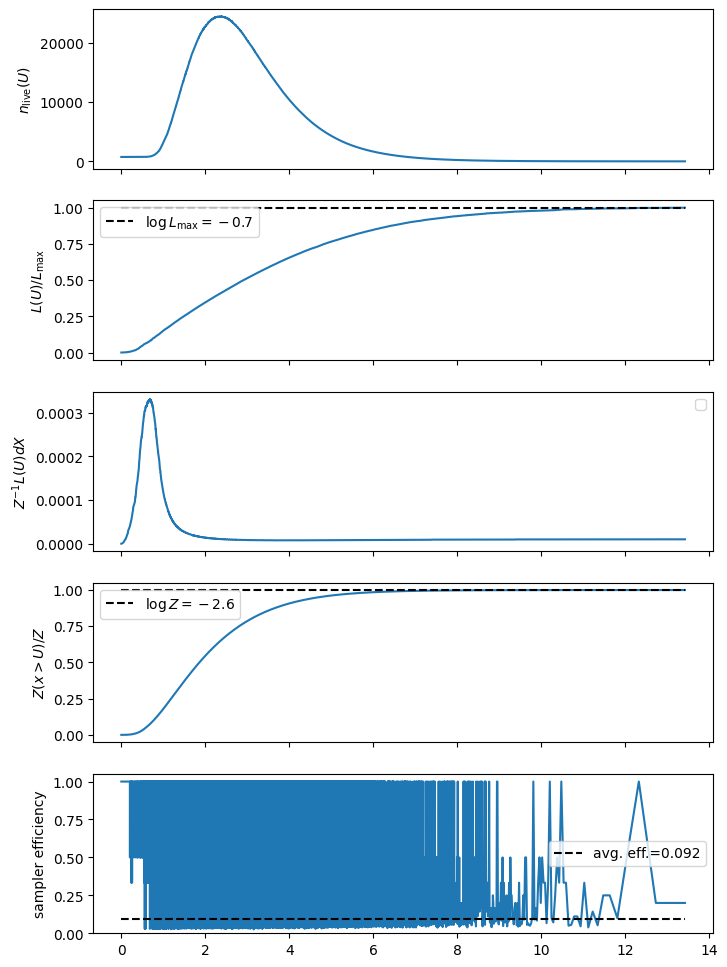

In [6]:
exact_ns.summary(results)
exact_ns.plot_diagnostics(results)

In [7]:
samples = resample(random.PRNGKey(45), results.samples, results.log_dp_mean, S=int(results.ESS), replace=True)


def predict(params):
    params_dict = unravel_func(params)
    logits = nn_model.apply(params_dict, x)
    return jax.nn.sigmoid(logits)[:, 0]


predictions = vmap(predict)(samples['params'])

for i in range(len(y)):
    print(f"{i}: {x[i]} -> {y[i]} | pred: {jnp.percentile(predictions[:, i], jnp.asarray([5, 50, 95]))}")

0: [1. 1. 1. 1. 1. 1. 1.] -> [ True] | pred: [7.340606e-04 4.987845e-01 9.992955e-01]
1: [1. 1. 1. 1. 1. 1. 0.] -> [False] | pred: [4.7429575e-04 4.9208707e-01 9.9942625e-01]
2: [1. 1. 1. 1. 1. 0. 1.] -> [False] | pred: [6.4651441e-04 4.8672405e-01 9.9936813e-01]
3: [1. 1. 1. 1. 1. 0. 0.] -> [ True] | pred: [4.0373896e-04 5.0067455e-01 9.9949431e-01]
4: [1. 1. 1. 1. 0. 1. 1.] -> [False] | pred: [5.8769167e-04 5.0469184e-01 9.9927819e-01]
5: [1. 1. 1. 1. 0. 1. 0.] -> [ True] | pred: [4.9224216e-04 5.0967044e-01 9.9958849e-01]
6: [1. 1. 1. 1. 0. 0. 1.] -> [ True] | pred: [5.673449e-04 5.036470e-01 9.995204e-01]
7: [1. 1. 1. 1. 0. 0. 0.] -> [False] | pred: [3.2951910e-04 5.1128024e-01 9.9957192e-01]
8: [1. 1. 1. 0. 1. 1. 1.] -> [False] | pred: [5.9327227e-04 5.0815701e-01 9.9953872e-01]
9: [1. 1. 1. 0. 1. 1. 0.] -> [ True] | pred: [4.3631002e-04 5.0659221e-01 9.9957401e-01]
10: [1. 1. 1. 0. 1. 0. 1.] -> [ True] | pred: [5.6649331e-04 4.9819478e-01 9.9957860e-01]
11: [1. 1. 1. 0. 1. 0. 0.]

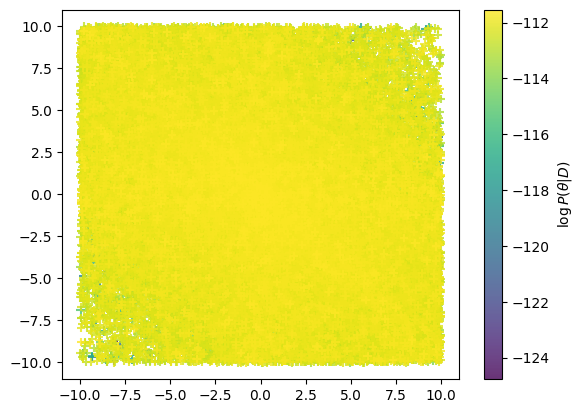

In [8]:

sc = plt.scatter(*results.samples['params'][:, -5:-3].T, marker='+', alpha=0.8, c=results.log_posterior_density)
plt.colorbar(sc, label=r'$\log P(\theta | D)$')
plt.show()

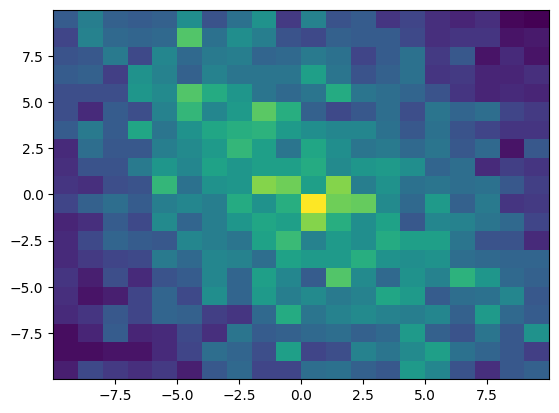

In [9]:
plt.hist2d(*samples['params'][:, -5:-3].T, bins=20)
plt.show()

In [10]:
from jax import value_and_grad
from jax._src.ops.special import logsumexp

num_bayesian = 5
perm = random.permutation(random.PRNGKey(42), jnp.arange(init_params_flat.size))
basyesian_dims, map_dims = perm[:num_bayesian], perm[num_bayesian:]


def mod_log_likelihood(bayes_params, map_params):
    """
    log(P(y|p))
    p = exp(logits)/1 - exp(logits)
    = log(p) * y + log(1-p) * (1-y)
    = logits * y1 - log(exp(-logits)/(exp(-logits) - 1)) * y0
    """
    params = init_params_flat.at[basyesian_dims].set(bayes_params)
    params = params.at[map_dims].set(map_params)
    return log_likelihood(params)


def evidence_maximisation_iter(params):
    map_params = params[map_dims]

    def prior_model():
        bayes_params = yield Prior(tfpd.Uniform(-10 * jnp.ones(num_bayesian), 10. * jnp.ones(num_bayesian)),
                                   name='params')
        return bayes_params, map_params

    model = Model(prior_model=prior_model, log_likelihood=mod_log_likelihood)

    model.sanity_check(random.PRNGKey(0), S=100)

    # Create the nested sampler class. In this case without any tuning.
    exact_ns = ExactNestedSampler(model=model, num_live_points=model.U_ndims * 20, max_samples=1e6,
                                  num_parallel_samplers=len(jax.devices()))

    termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-5))
    results = exact_ns.to_results(state, termination_reason)
    exact_ns.summary(results)

    samples = resample(random.PRNGKey(0), results.samples, log_weights=results.log_dp_mean, S=100)

    def loss(map_params):
        return -logsumexp(vmap(lambda bayes_params: mod_log_likelihood(bayes_params, map_params))(samples['params']))

    value_and_grad_fn = value_and_grad(loss)
    for _ in range(100):
        value, g = value_and_grad_fn(map_params)
        map_params = map_params - g
        print(value, jnp.linalg.norm(g))
    return map_params



In [11]:
params = evidence_maximisation_iter(init_params_flat)
params = evidence_maximisation_iter(params)
params = evidence_maximisation_iter(params)

/tmp/ipykernel_131862/216712798.py:34: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.asarray(log_prob, jnp.float64)
INFO[2023-06-15 15:12:40,184]: Sanity check...
INFO[2023-06-15 15:12:40,427]: Sanity check passed
WARNING[2023-06-15 15:12:40,428]: Increasing num_live_points (100) by 2 to closest multiple of num_parallel_samplers.
/home/albert/miniconda3/envs/jaxns_py/lib/python3.10/site-packages/jax/_src/dispatch.py:400: UserWarning: The jitted function fresh_run includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unle

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 100879
# samples: 18870
# slices: 0.0
# slices / acceptance: nan
# likelihood evals / sample: 5.3
# likelihood evals / slice: nan
--------
logZ=-0.69908 +- 0.00035
H=1.2
ESS=5404
--------
params[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
params[0]: 0.0 +- 5.8 | -8.0 / 0.1 / 8.0 | 9.6 | 9.6
params[1]: -0.2 +- 5.7 | -7.9 / -0.4 / 7.9 | 0.2 | 0.2
params[2]: -0.1 +- 5.8 | -8.0 / -0.2 / 8.0 | -5.0 | -5.0
params[3]: -0.1 +- 5.7 | -8.0 / -0.2 / 7.8 | -0.7 | -0.7
params[4]: -0.0 +- 5.8 | -8.0 / 0.0 / 8.0 | -1.1 | -1.1
--------


/tmp/ipykernel_131862/216712798.py:34: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.asarray(log_prob, jnp.float64)


-3.9066687 0.03550352
-3.907674 0.021949982
-3.9080842 0.016197657
-3.908326 0.01401322
-3.9085145 0.013134369
-3.908684 0.01266504
-3.9088423 0.012318964
-3.908992 0.012012689
-3.9091346 0.011722546
-3.9092703 0.011441798
-3.9093995 0.011168452
-3.9095225 0.010901838
-3.9096403 0.010641653
-3.9097524 0.010387718
-3.9098587 0.010139866
-3.9099605 0.009897952
-3.9100573 0.009661834
-3.9101496 0.009431372
-3.9102376 0.009206437
-3.9103208 0.008986892
-3.9104006 0.008772609
-3.9104767 0.0085634645
-3.9105492 0.0083593335
-3.9106183 0.0081601
-3.910684 0.007965643
-3.910747 0.0077758483
-3.9108067 0.007590606
-3.9108639 0.007409809
-3.9109178 0.0072333463
-3.9109693 0.007061118
-3.9110188 0.0068930206
-3.9110656 0.006728953
-3.9111104 0.006568823
-3.9111533 0.0064125326
-3.9111936 0.006259992
-3.9112327 0.0061111115
-3.9112694 0.0059658
-3.9113045 0.0058239736
-3.911338 0.0056855483
-3.91137 0.005550443
-3.9114003 0.0054185786
-3.9114296 0.0052898745
-3.911457 0.0051642586
-3.9114835 0.005

INFO[2023-06-15 15:17:38,749]: Sanity check...
INFO[2023-06-15 15:17:38,751]: Sanity check passed
WARNING[2023-06-15 15:17:38,752]: Increasing num_live_points (100) by 2 to closest multiple of num_parallel_samplers.
/home/albert/miniconda3/envs/jaxns_py/lib/python3.10/site-packages/jax/_src/dispatch.py:400: UserWarning: The jitted function fresh_run includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(
/tmp/ipykernel_131862/216712798.py:34: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 47715
# samples: 9180
# slices: 0.0
# slices / acceptance: nan
# likelihood evals / sample: 5.2
# likelihood evals / slice: nan
--------
logZ=-0.6979 +- 0.0053
H=1.2
ESS=170
--------
params[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
params[0]: 0.9 +- 5.4 | -7.1 / 1.5 / 7.7 | -3.6 | -3.6
params[1]: 2.1 +- 5.5 | -6.2 / 2.9 / 8.8 | -2.0 | -2.0
params[2]: 2.5 +- 6.1 | -7.7 / 4.5 / 9.2 | -3.2 | -3.2
params[3]: 2.5 +- 5.5 | -7.0 / 3.7 / 8.6 | -8.7 | -8.7
params[4]: 3.2 +- 5.7 | -6.8 / 5.3 / 9.1 | -4.7 | -4.7
--------


/tmp/ipykernel_131862/216712798.py:34: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.asarray(log_prob, jnp.float64)


-3.9120226 0.00054803176
-3.912023 0.00024538403
-3.912023 0.00010994117
-3.912023 4.939137e-05
-3.912023 2.248366e-05
-3.912023 1.08306995e-05
-3.912023 6.2418653e-06
-3.912023 4.7628546e-06
-3.912023 4.346345e-06
-3.912023 4.196246e-06
-3.912023 4.1049025e-06
-3.912023 4.0270493e-06
-3.912023 3.9530246e-06
-3.912023 3.8808835e-06
-3.912023 3.8105304e-06
-3.912023 3.7412537e-06
-3.912023 3.6732556e-06
-3.912023 3.606684e-06
-3.912023 3.541425e-06
-3.912023 3.477372e-06
-3.912023 3.414462e-06
-3.912023 3.3528438e-06
-3.912023 3.2923354e-06
-3.912023 3.2331172e-06
-3.912023 3.1747502e-06
-3.912023 3.117878e-06
-3.912023 3.0615702e-06
-3.912023 3.0068193e-06
-3.912023 2.9528542e-06
-3.912023 2.8998893e-06
-3.912023 2.8481102e-06
-3.912023 2.7971287e-06
-3.912023 2.7471342e-06
-3.912023 2.6980379e-06
-3.912023 2.6499474e-06
-3.912023 2.6026466e-06
-3.912023 2.556365e-06
-3.912023 2.5107938e-06
-3.912023 2.466102e-06
-3.912023 2.422264e-06
-3.912023 2.379324e-06
-3.912023 2.337004e-06
-3.9

INFO[2023-06-15 15:20:21,040]: Sanity check...
INFO[2023-06-15 15:20:21,043]: Sanity check passed
WARNING[2023-06-15 15:20:21,044]: Increasing num_live_points (100) by 2 to closest multiple of num_parallel_samplers.
/home/albert/miniconda3/envs/jaxns_py/lib/python3.10/site-packages/jax/_src/dispatch.py:400: UserWarning: The jitted function fresh_run includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(
/tmp/ipykernel_131862/216712798.py:34: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https

--------
Termination Conditions:
--------
# likelihood evals: 102
# samples: 102
# slices: 0.0
# slices / acceptance: nan
# likelihood evals / sample: 1.0
# likelihood evals / slice: nan
--------
logZ=-0.708 +- 0.011
H=1.2
ESS=51
--------
params[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
params[0]: 0.5 +- 5.9 | -9.2 / 2.0 / 8.1 | -0.7 | -0.7
params[1]: -0.0 +- 6.1 | -7.9 / 1.1 / 7.3 | -4.4 | -4.4
params[2]: 1.6 +- 5.9 | -7.1 / 3.5 / 8.5 | 7.0 | 7.0
params[3]: 0.2 +- 5.1 | -6.0 / -1.0 / 9.0 | 3.4 | 3.4
params[4]: -0.1 +- 5.8 | -7.7 / -1.4 / 8.5 | -8.1 | -8.1
--------


/tmp/ipykernel_131862/216712798.py:34: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.asarray(log_prob, jnp.float64)


-3.912023 3.3266297e-06
-3.912023 1.5949678e-06
-3.912023 7.657845e-07
-3.912023 3.683596e-07
-3.912023 1.7924754e-07
-3.912023 8.944864e-08
-3.912023 5.287576e-08
-3.912023 3.4318283e-08
-3.912023 2.8715434e-08
-3.912023 2.7137363e-08
-3.912023 2.643468e-08
-3.912023 2.5939821e-08
-3.912023 2.5411273e-08
-3.912023 2.4957913e-08
-3.912023 2.45914e-08
-3.912023 2.4145255e-08
-3.912023 2.3802329e-08
-3.912023 2.346719e-08
-3.912023 2.3054966e-08
-3.912023 2.2634984e-08
-3.912023 2.2269775e-08
-3.912023 2.2006615e-08
-3.912023 2.173581e-08
-3.912023 2.1405448e-08
-3.912023 2.1077167e-08
-3.912023 2.0740975e-08
-3.912023 2.0401288e-08
-3.912023 2.0068027e-08
-3.912023 1.9727965e-08
-3.912023 1.9371363e-08
-3.912023 1.9007585e-08
-3.912023 1.8730427e-08
-3.912023 1.8415106e-08
-3.912023 1.8126771e-08
-3.912023 1.78252e-08
-3.912023 1.7527732e-08
-3.912023 1.7281181e-08
-3.912023 1.7004407e-08
-3.912023 1.6735804e-08
-3.912023 1.6446347e-08
-3.912023 1.6153614e-08
-3.912023 1.582361e-08
-3.9